In [43]:
import requests
from pathlib import Path
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
from torch import nn

In [2]:
# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise= 0.03, random_state =42)
len(X), len(y)
print (f"First 5 samples of X\n {X[:5]}")
print (f"First 5 samples of y\n {y[:5]}")

First 5 samples of X
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y
 [1 1 1 1 0]


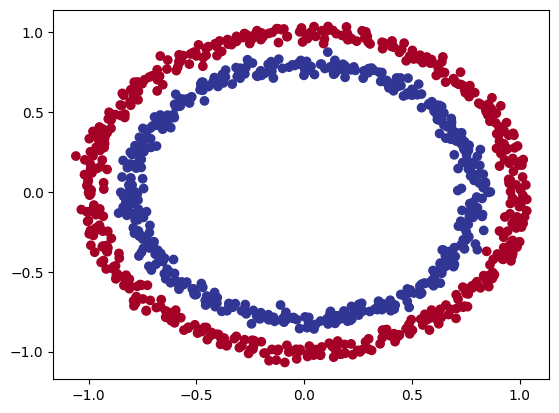

In [3]:
df_circles = pd.DataFrame({"X1": X[:, 0],
                          "X2": X[:, 1],
                          "label": y})

plt.scatter (x = X[:,0],
             y = X[:, 1],
             c = y,
             cmap = plt.cm.RdYlBu);

In [4]:
# print(f'sample x : {X[0]} shape x sample {X[0].shape} y sample, shape {y[0], y[0.shape]}')
print(f'sample x: {X[0]}, shape x sample: {X[0].shape}, y sample: {y[0]}, shape y sample: {y[0].shape}')


sample x: [0.75424625 0.23148074], shape x sample: (2,), y sample: 1, shape y sample: ()


In [5]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [6]:
type (X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [7]:
# train test split using scikit learn
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
# create model
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features=8)
        self.layer_2 = nn.Linear(in_features = 8, out_features=1)
        
    def forward (self, x):
        return self.layer_2(self.layer_1(x))
    
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).devicec

device(type='cuda', index=0)

In [20]:
# sequential model
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features = 8),
    nn.Linear(in_features= 8, out_features = 1)  
    ).to(device)
model_0


Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6986,  0.6810],
                      [ 0.3576,  0.4165],
                      [ 0.1043,  0.1654],
                      [ 0.5872, -0.2122],
                      [ 0.1868,  0.2230],
                      [-0.2881,  0.6195],
                      [ 0.3301, -0.6981],
                      [ 0.0807,  0.2751]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1682, -0.4258,  0.0973, -0.5223, -0.0876, -0.2610, -0.4337,  0.1893],
                     device='cuda:0')),
             ('1.weight',
              tensor([[-0.3408, -0.2147,  0.0599, -0.3080,  0.1800,  0.1220,  0.2503,  0.2153]],
                     device='cuda:0')),
             ('1.bias', tensor([-0.1525], device='cuda:0'))])

In [27]:
# untrained predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print (f'Pred len: {len(untrained_preds)} Shape: {untrained_preds.shape}')
print (f'Sample Len: {len(X_test)} Shape {X_test.shape}')
print (f'\First 10 preds : \n {torch.round(untrained_preds[:10])}')
print (f'nFirst 10 labels\n {y_test[:10]}')

Pred len: 200 Shape: torch.Size([200, 1])
Sample Len: 200 Shape torch.Size([200, 2])
\First 10 preds : 
 tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], device='cuda:0')
nFirst 10 labels
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [36]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimzer = torch.optim.SGD(params =model_0.parameters(),lr= 0.1)

In [40]:
# calculate accurate
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [30]:
# look at logits
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
    
y_logits
    

tensor([[-0.2669],
        [-0.3019],
        [-0.0495],
        [-0.3291],
        [ 0.1501]], device='cuda:0')

In [34]:
# change to probabilities
y_pred_probs = torch.sigmoid(y_logits)
torch.round(y_pred_probs).squeeze(), y_pred_probs.squeeze()

(tensor([0., 0., 0., 0., 1.], device='cuda:0'),
 tensor([0.4337, 0.4251, 0.4876, 0.4185, 0.5375], device='cuda:0'))

In [41]:
# train and test loop
# set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set epocs
epochs = 100

# put data in device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range (epochs):
    #train
    model_0.train()
    
    # forward
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round (torch.sigmoid(y_logits))
    
    # calucate loss
    loss = loss_fn (y_logits,
                    y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred=y_pred)
    
    # optimizer zero grad
    optimzer.zero_grad()
    
    # optimizer step
    optimzer.step()
    
    # 
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_train,
                               y_pred = y_pred) 
        
    #print
    if epoch % 10 == 0:
        print (f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} test_acc {test_acc:.2f}%')
          

Epoch: 0 | Loss: 0.69826, Acc: 48.38% | Test loss: 0.69300 test_acc 48.38%
Epoch: 10 | Loss: 0.69826, Acc: 48.38% | Test loss: 0.69300 test_acc 48.38%
Epoch: 20 | Loss: 0.69826, Acc: 48.38% | Test loss: 0.69300 test_acc 48.38%
Epoch: 30 | Loss: 0.69826, Acc: 48.38% | Test loss: 0.69300 test_acc 48.38%
Epoch: 40 | Loss: 0.69826, Acc: 48.38% | Test loss: 0.69300 test_acc 48.38%
Epoch: 50 | Loss: 0.69826, Acc: 48.38% | Test loss: 0.69300 test_acc 48.38%
Epoch: 60 | Loss: 0.69826, Acc: 48.38% | Test loss: 0.69300 test_acc 48.38%
Epoch: 70 | Loss: 0.69826, Acc: 48.38% | Test loss: 0.69300 test_acc 48.38%
Epoch: 80 | Loss: 0.69826, Acc: 48.38% | Test loss: 0.69300 test_acc 48.38%
Epoch: 90 | Loss: 0.69826, Acc: 48.38% | Test loss: 0.69300 test_acc 48.38%


In [45]:
# visualize erros
if Path("helper_function.py").is_file():
    print ('helper function exists')
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

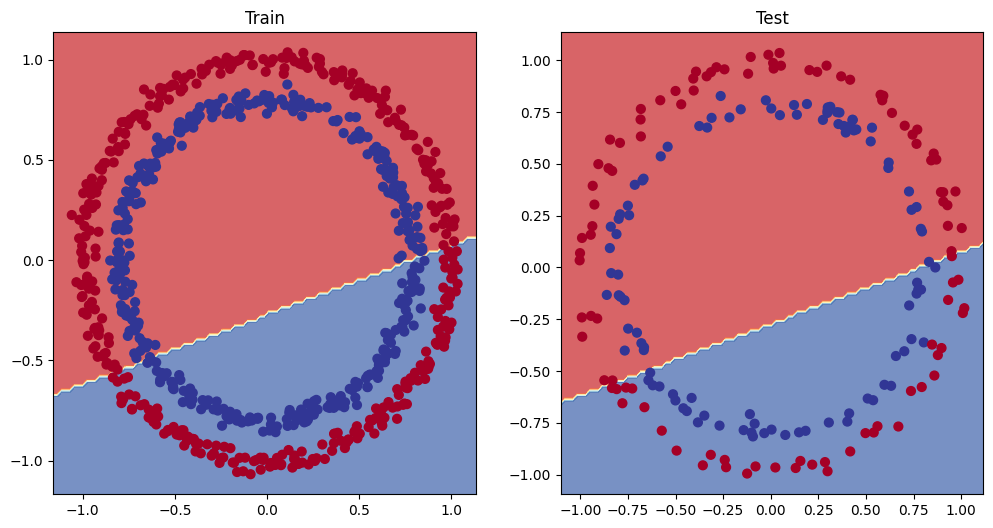

In [47]:
# plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot (1,2, 1)
plt.title ("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot (1, 2, 2)
plt.title ("Test")
plot_decision_boundary(model_0, X_test, y_test)